## Librerias requeridas

Configuración inicial para modo de ejecución

In [1]:
flag_runlocal = True    # "False" para ejecutar en google colab

Las librerías a continuación han sido desarrolladas para estre curso. Éstas se encargan del procesamiento del modelo, la implementación numérica de la solución y calculos de productos asociados (IRF, KF y proyección), ademas del manejo de los datos.

In [2]:
import sys
import os

if flag_runlocal:
    # ---> Ejecución local
    pathPolMon = os.getcwd() + '/'

else:
    # ---> Desde github-to-colab
    !git clone https://github.com/RondasDMM/CUECOPolMon.git
    pathPolMon = '/content/CUECOPolMon/'

sys.path.append(pathPolMon+'02_Libraries')
import DSGE_LinearMethods as DLM
import DSGE_PreProcessing as DPP
import HandleTimeSeries as HTS
import sympy as sp
sp.init_session(use_latex=True)

IPython console for SymPy 1.11.1 (Python 3.11.5-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.11.1/



Librería externas complementarias

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# IRF
Horizon=20

## Procesamiento el modelo

In [5]:
Mod = DPP.process_file3(pathPolMon+'04_Modelo/MPTBolsillo.txt')

In [6]:
var = DLM.sympy_to_list(Mod['Desc.']['Declared Endogenous'])
varexo = DLM.sympy_to_list(Mod['Desc.']['Shocks'])

1. Se cargan los datos de variables observables. Estas se recaban de instituciones de estadísticas y se sintetizan para que sean insumidas por el modelo.

In [7]:
Describ, DBobs = HTS.ReadDB_excel(pathPolMon+'03_DB/DataClase.xlsx', sheet='DataSim')

### Solución del modelo y estimaciones

A continuación se resuelve el modelo y se verifican las condiciones de estabilidad.
Es necesario incluir una calibración de coeficientes y un estado estacionario (**ver**: 04_Modelo/Cal_MPTBolsillo.txt)

**Nota**: En caso deseen hacer cambios en coeficientes, estos deben ocurrir en esta etapa

- Solución del modelo
- Estimación de IRF
- Filtro de Kalman

Se proyectarán 8 trimestres desde el último periodo de información 2024Q4. 

La proyección es libre de condicionantes. En consecuencia, se observa la convergencia de la economía hacia su estado estacionario, tomando como punto de partida la situación inicial. Cabe destacar que ciertas variables presentan dependencia de múltiples rezagos.

In [8]:
FH = 8 # Horizonte de proyección (2 años)
StartingPeriod = '2025Q1'

In [9]:
Mod_base   = DLM.SolveModel(Mod, pathPolMon+"04_Modelo/Cal_MPTBolsillo.txt", False)
IRF_base   = DLM.getIRF(Mod_base,Horizon)
DF_s_base, DF_u_base, minuslogL_base = DLM.KFts(DBobs, Mod_base, {'diffuse':False})
Data_base  = DF_s_base.copy()
FDB_base = DLM.DSGEforecast0(Mod_base,Data_base,FH,StartingPeriod)

In [10]:
Mod_alt    = DLM.SolveModel(Mod, pathPolMon+"04_Modelo/Cal_MPTBolsilloAlt.txt", False)
IRF_alt    = DLM.getIRF(Mod_alt,Horizon)
DF_s_alt, DF_u_alt, minuslogL_alt = DLM.KFts(DBobs, Mod_alt, {'diffuse':False}) 
Data_alt   = DF_s_alt.copy()
FDB_alt  = DLM.DSGEforecast0(Mod_alt,Data_base,FH,StartingPeriod)

$ Dpsae \rightarrow (ED4p, Dp) \rightarrow i$

$ i \rightarrow y \rightarrow (ED4p, Dpsae) \rightarrow Dp$

Text(0.5, 1.0, 'Respuestas de la TPM')

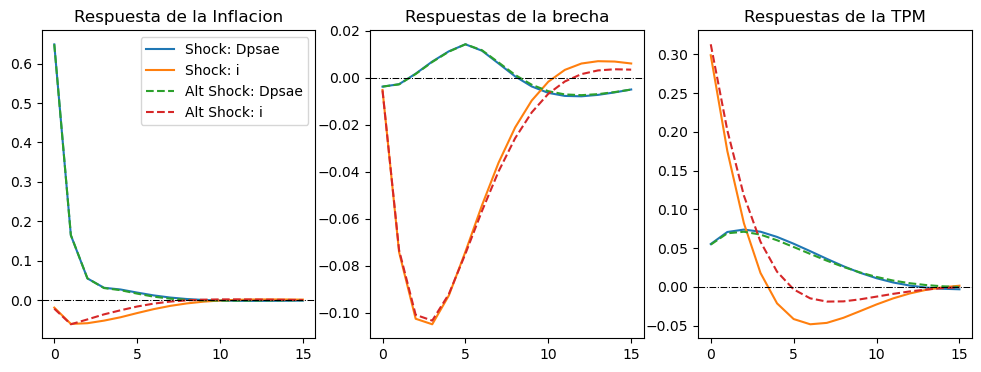

In [11]:
TP = 16   # Horizon to plot (<=Horizon)

shockslist = ['res_Dpsae','res_i']
varslist = ['Dp','y','i']

fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].plot(IRF_base[shockslist[0]].index[:TP], IRF_base[shockslist[0]][varslist[0]][:TP], linestyle='-',label="Shock: Dpsae")
axs[0].plot(IRF_base[shockslist[1]].index[:TP], IRF_base[shockslist[1]][varslist[0]][:TP], linestyle='-',label="Shock: i")
axs[0].plot(IRF_alt[shockslist[0]].index[:TP], IRF_alt[shockslist[0]][varslist[0]][:TP], linestyle='--',label="Alt Shock: Dpsae")
axs[0].plot(IRF_alt[shockslist[1]].index[:TP], IRF_alt[shockslist[1]][varslist[0]][:TP], linestyle='--',label="Alt Shock: i")
axs[0].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[0].set_title("Respuesta de la Inflacion")
axs[0].legend(loc="best")

axs[1].plot(IRF_base[shockslist[0]].index[:TP], IRF_base[shockslist[0]][varslist[1]][:TP], linestyle='-',label="Shock: Dpsae")
axs[1].plot(IRF_base[shockslist[1]].index[:TP], IRF_base[shockslist[1]][varslist[1]][:TP], linestyle='-',label="Shock: i")
axs[1].plot(IRF_alt[shockslist[0]].index[:TP], IRF_alt[shockslist[0]][varslist[1]][:TP], linestyle='--',label="Alt Shock: Dpsae")
axs[1].plot(IRF_alt[shockslist[1]].index[:TP], IRF_alt[shockslist[1]][varslist[1]][:TP], linestyle='--',label="Alt Shock: i")
axs[1].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[1].set_title("Respuestas de la brecha")

axs[2].plot(IRF_base[shockslist[0]].index[:TP], IRF_base[shockslist[0]][varslist[2]][:TP], linestyle='-',label="Shock: Dpsae")
axs[2].plot(IRF_base[shockslist[1]].index[:TP], IRF_base[shockslist[1]][varslist[2]][:TP], linestyle='-',label="Shock: i")
axs[2].plot(IRF_alt[shockslist[0]].index[:TP], IRF_alt[shockslist[0]][varslist[2]][:TP], linestyle='--',label="Alt Shock: Dpsae")
axs[2].plot(IRF_alt[shockslist[1]].index[:TP], IRF_alt[shockslist[1]][varslist[2]][:TP], linestyle='--',label="Alt Shock: i")
axs[2].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[2].set_title("Respuestas de la TPM")

**Proyección incondicional**

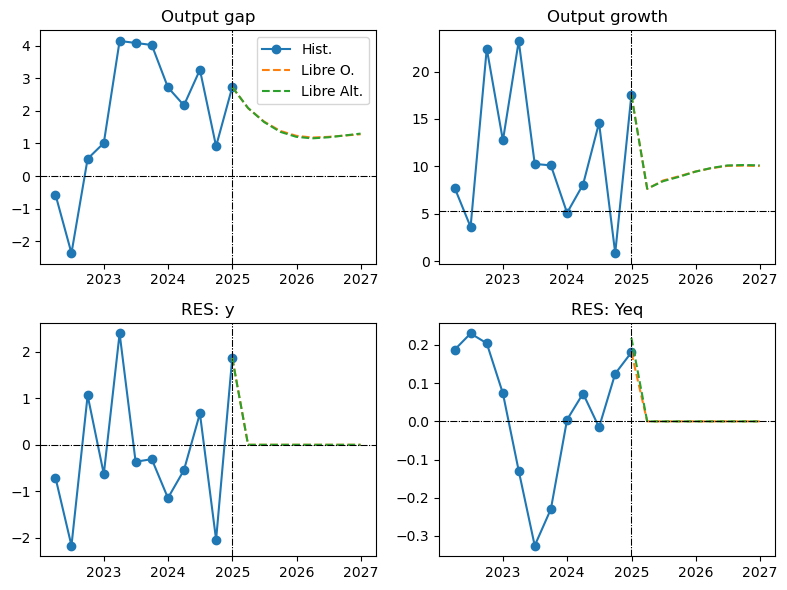

In [12]:
DBdict = {'Libre O.': FDB_base, 'Libre Alt.': FDB_alt}
lista = ['y','DY','res_y','res_DY_eq']
listanames = ['Output gap','Output growth','RES: y','RES: Yeq']
listaSS = [0,5.3,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 2
fig, axs = HTS.plotTSforecast(DBdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

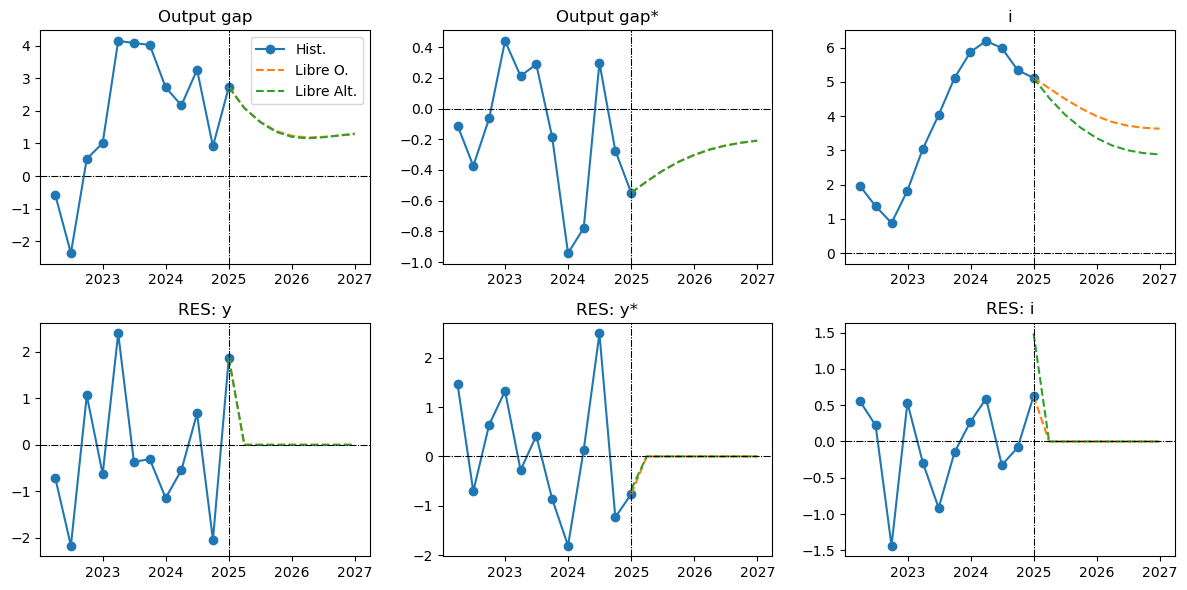

In [13]:
lista = ['y','ys', 'i','res_y','res_ys', 'res_i']
listanames = ['Output gap','Output gap*', 'i','RES: y','RES: y*', 'RES: i']
listaSS = [0,0,0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 3
fig, axs = HTS.plotTSforecast(DBdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

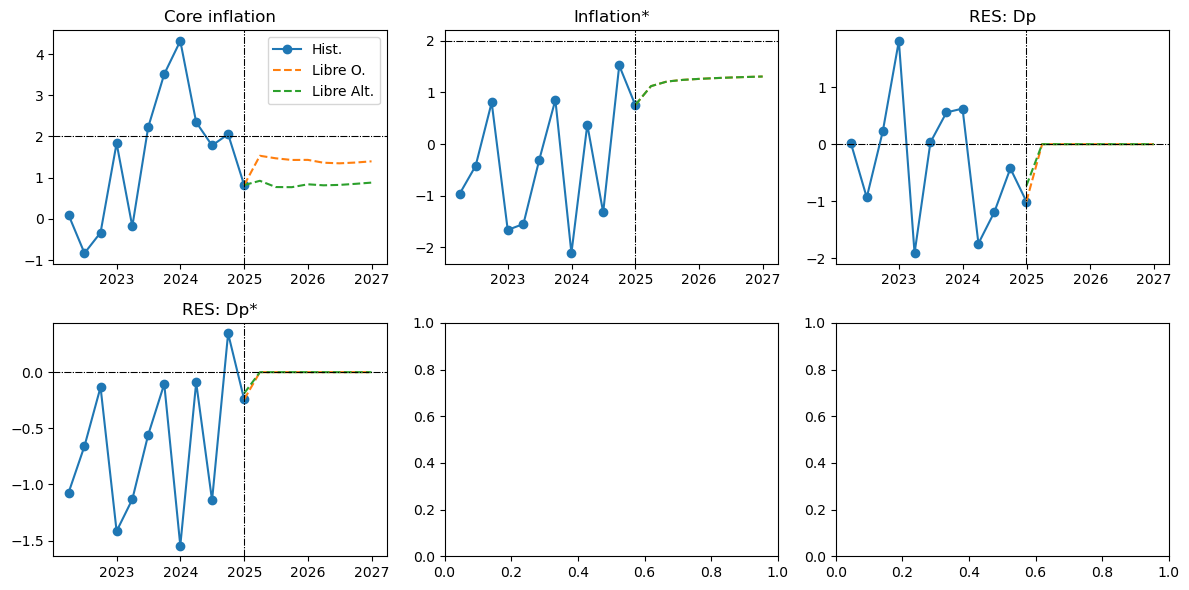

In [14]:
lista = ['Dpsae','Dps','res_Dpsae','res_Dps']
listanames = ['Core inflation','Inflation*','RES: Dp','RES: Dp*']
listaSS = [2,2,0,0]
fig, axs = HTS.plotTSforecast(DBdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

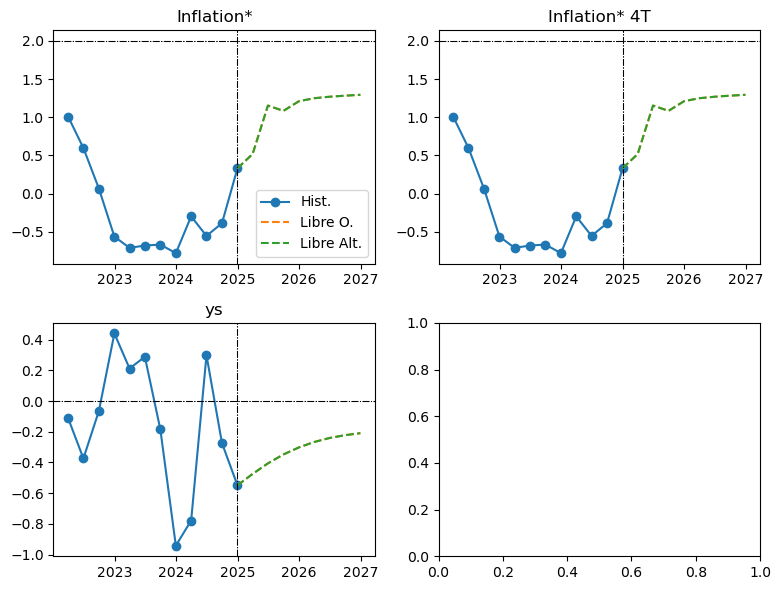

In [15]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['D4ps','D4ps','ys']
listaSS = [2,2,0]
listanames = ['Inflation*','Inflation* 4T','ys']

fig, axs = HTS.plotTSforecast(DBdict,lista,listanames,listaSS,FH,HH,2,2)

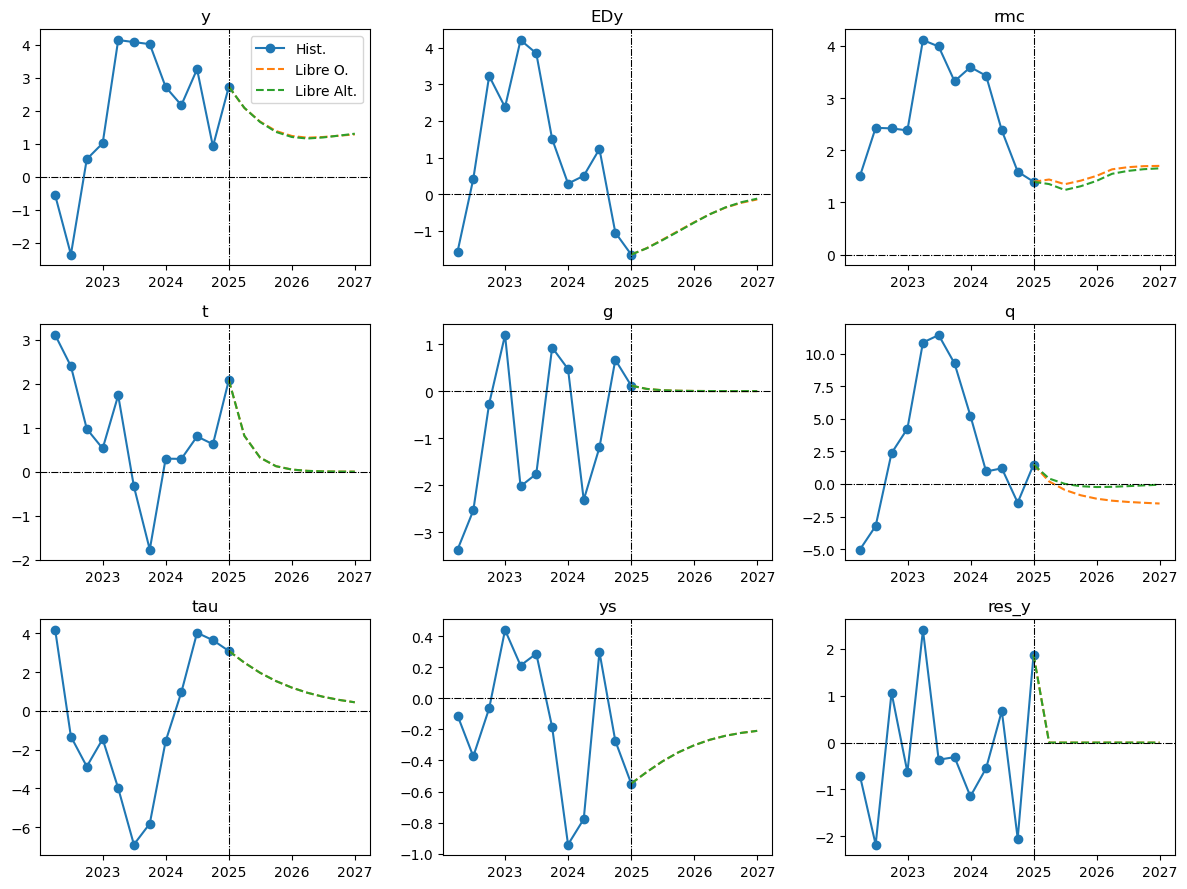

In [16]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(DBdict,lista,listanames,listaSS,FH,HH,3,3)